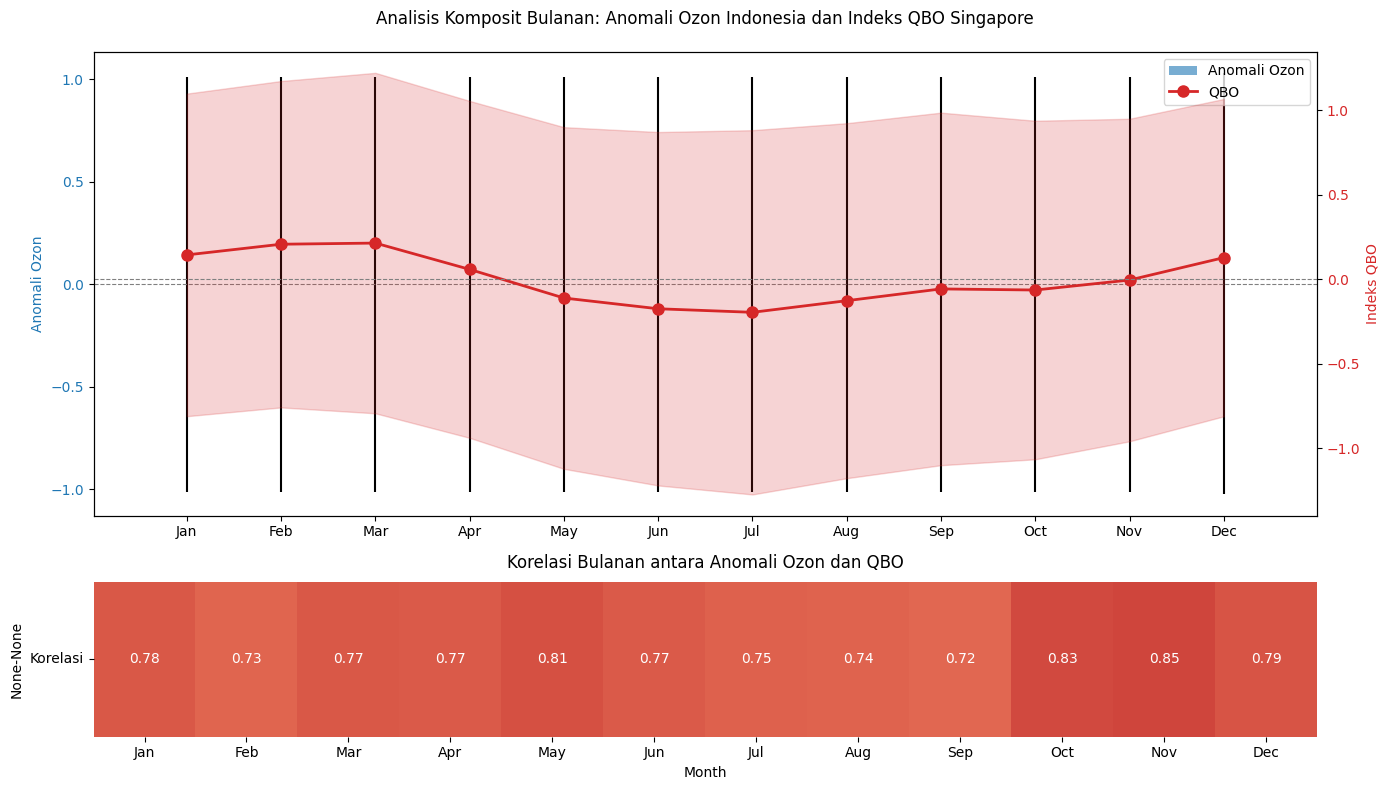

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec

# 1. Load data
ausmi = pd.read_excel('QBO Data.xlsx')
ch_anom = pd.read_excel('Ozone_Anomaly.xlsx')

# 2. Konversi kolom Date dan ekstraksi tahun-bulan
for df in [ausmi, ch_anom]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

# 3. Gabungkan data
merged = pd.merge(ch_anom, ausmi, on=['Date', 'Year', 'Month'], suffixes=('_CH', '_AUSMI'))

# Tambahkan nama bulan setelah penggabungan
merged['Month_Name'] = merged['Month'].apply(lambda x: pd.to_datetime(f'2023-{x:02d}-01').strftime('%B'))

# 4. Hitung rata-rata dan standar deviasi per bulan
monthly_avg = merged.groupby(['Month'])[['TCO', 'QBO']].mean().reset_index()
monthly_std = merged.groupby(['Month'])[['TCO', 'QBO']].std().reset_index()

# Tambahkan nama bulan agar bisa digunakan untuk sumbu x
monthly_avg['Month_Name'] = monthly_avg['Month'].apply(lambda x: pd.to_datetime(f'2023-{x:02d}-01').strftime('%b'))
monthly_std['Month_Name'] = monthly_std['Month'].apply(lambda x: pd.to_datetime(f'2023-{x:02d}-01').strftime('%b'))

# Urutkan berdasarkan bulan
monthly_avg = monthly_avg.sort_values('Month')
monthly_std = monthly_std.sort_values('Month')

# 5. Plot komposit bulanan
plt.figure(figsize=(14, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1])

# Panel atas: Rata-rata anomali dan AUSMI
ax1 = plt.subplot(gs[0])

# Anomali CH
color = 'tab:blue'
ax1.bar(monthly_avg['Month_Name'], monthly_avg['TCO'],
        yerr=monthly_std['TCO'],
        color=color, alpha=0.6,
        label='Anomali Ozon')
ax1.set_ylabel('Anomali Ozon', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# AUSMI (sumbu kanan)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(monthly_avg['Month_Name'], monthly_avg['QBO'],
         color=color, marker='o', linewidth=2, markersize=8,
         label='QBO')
ax2.fill_between(monthly_avg['Month_Name'],
                 monthly_avg['QBO'] - monthly_std['QBO'],
                 monthly_avg['QBO'] + monthly_std['QBO'],
                 color=color, alpha=0.2)
ax2.set_ylabel('Indeks QBO', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Gabung legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_title('Analisis Komposit Bulanan: Anomali Ozon Indonesia dan Indeks QBO Singapore', pad=20)

# Panel bawah: Korelasi bulanan
ax3 = plt.subplot(gs[1])
corr_data = merged.groupby('Month')[['TCO', 'QBO']].corr().unstack().loc[:, ('TCO', 'QBO')]
sns.heatmap(pd.DataFrame(corr_data).T,
            annot=True, cmap='coolwarm',
            vmin=-1, vmax=1,
            cbar=False, ax=ax3,
            xticklabels=monthly_avg['Month_Name'])
ax3.set_title('Korelasi Bulanan antara Anomali Ozon dan QBO', pad=10)
ax3.set_yticklabels(['Korelasi'], rotation=0)

plt.tight_layout()
# plt.savefig('Komposit_Bulanan_CH_AUSMI.png', dpi=300, bbox_inches='tight')
plt.show()


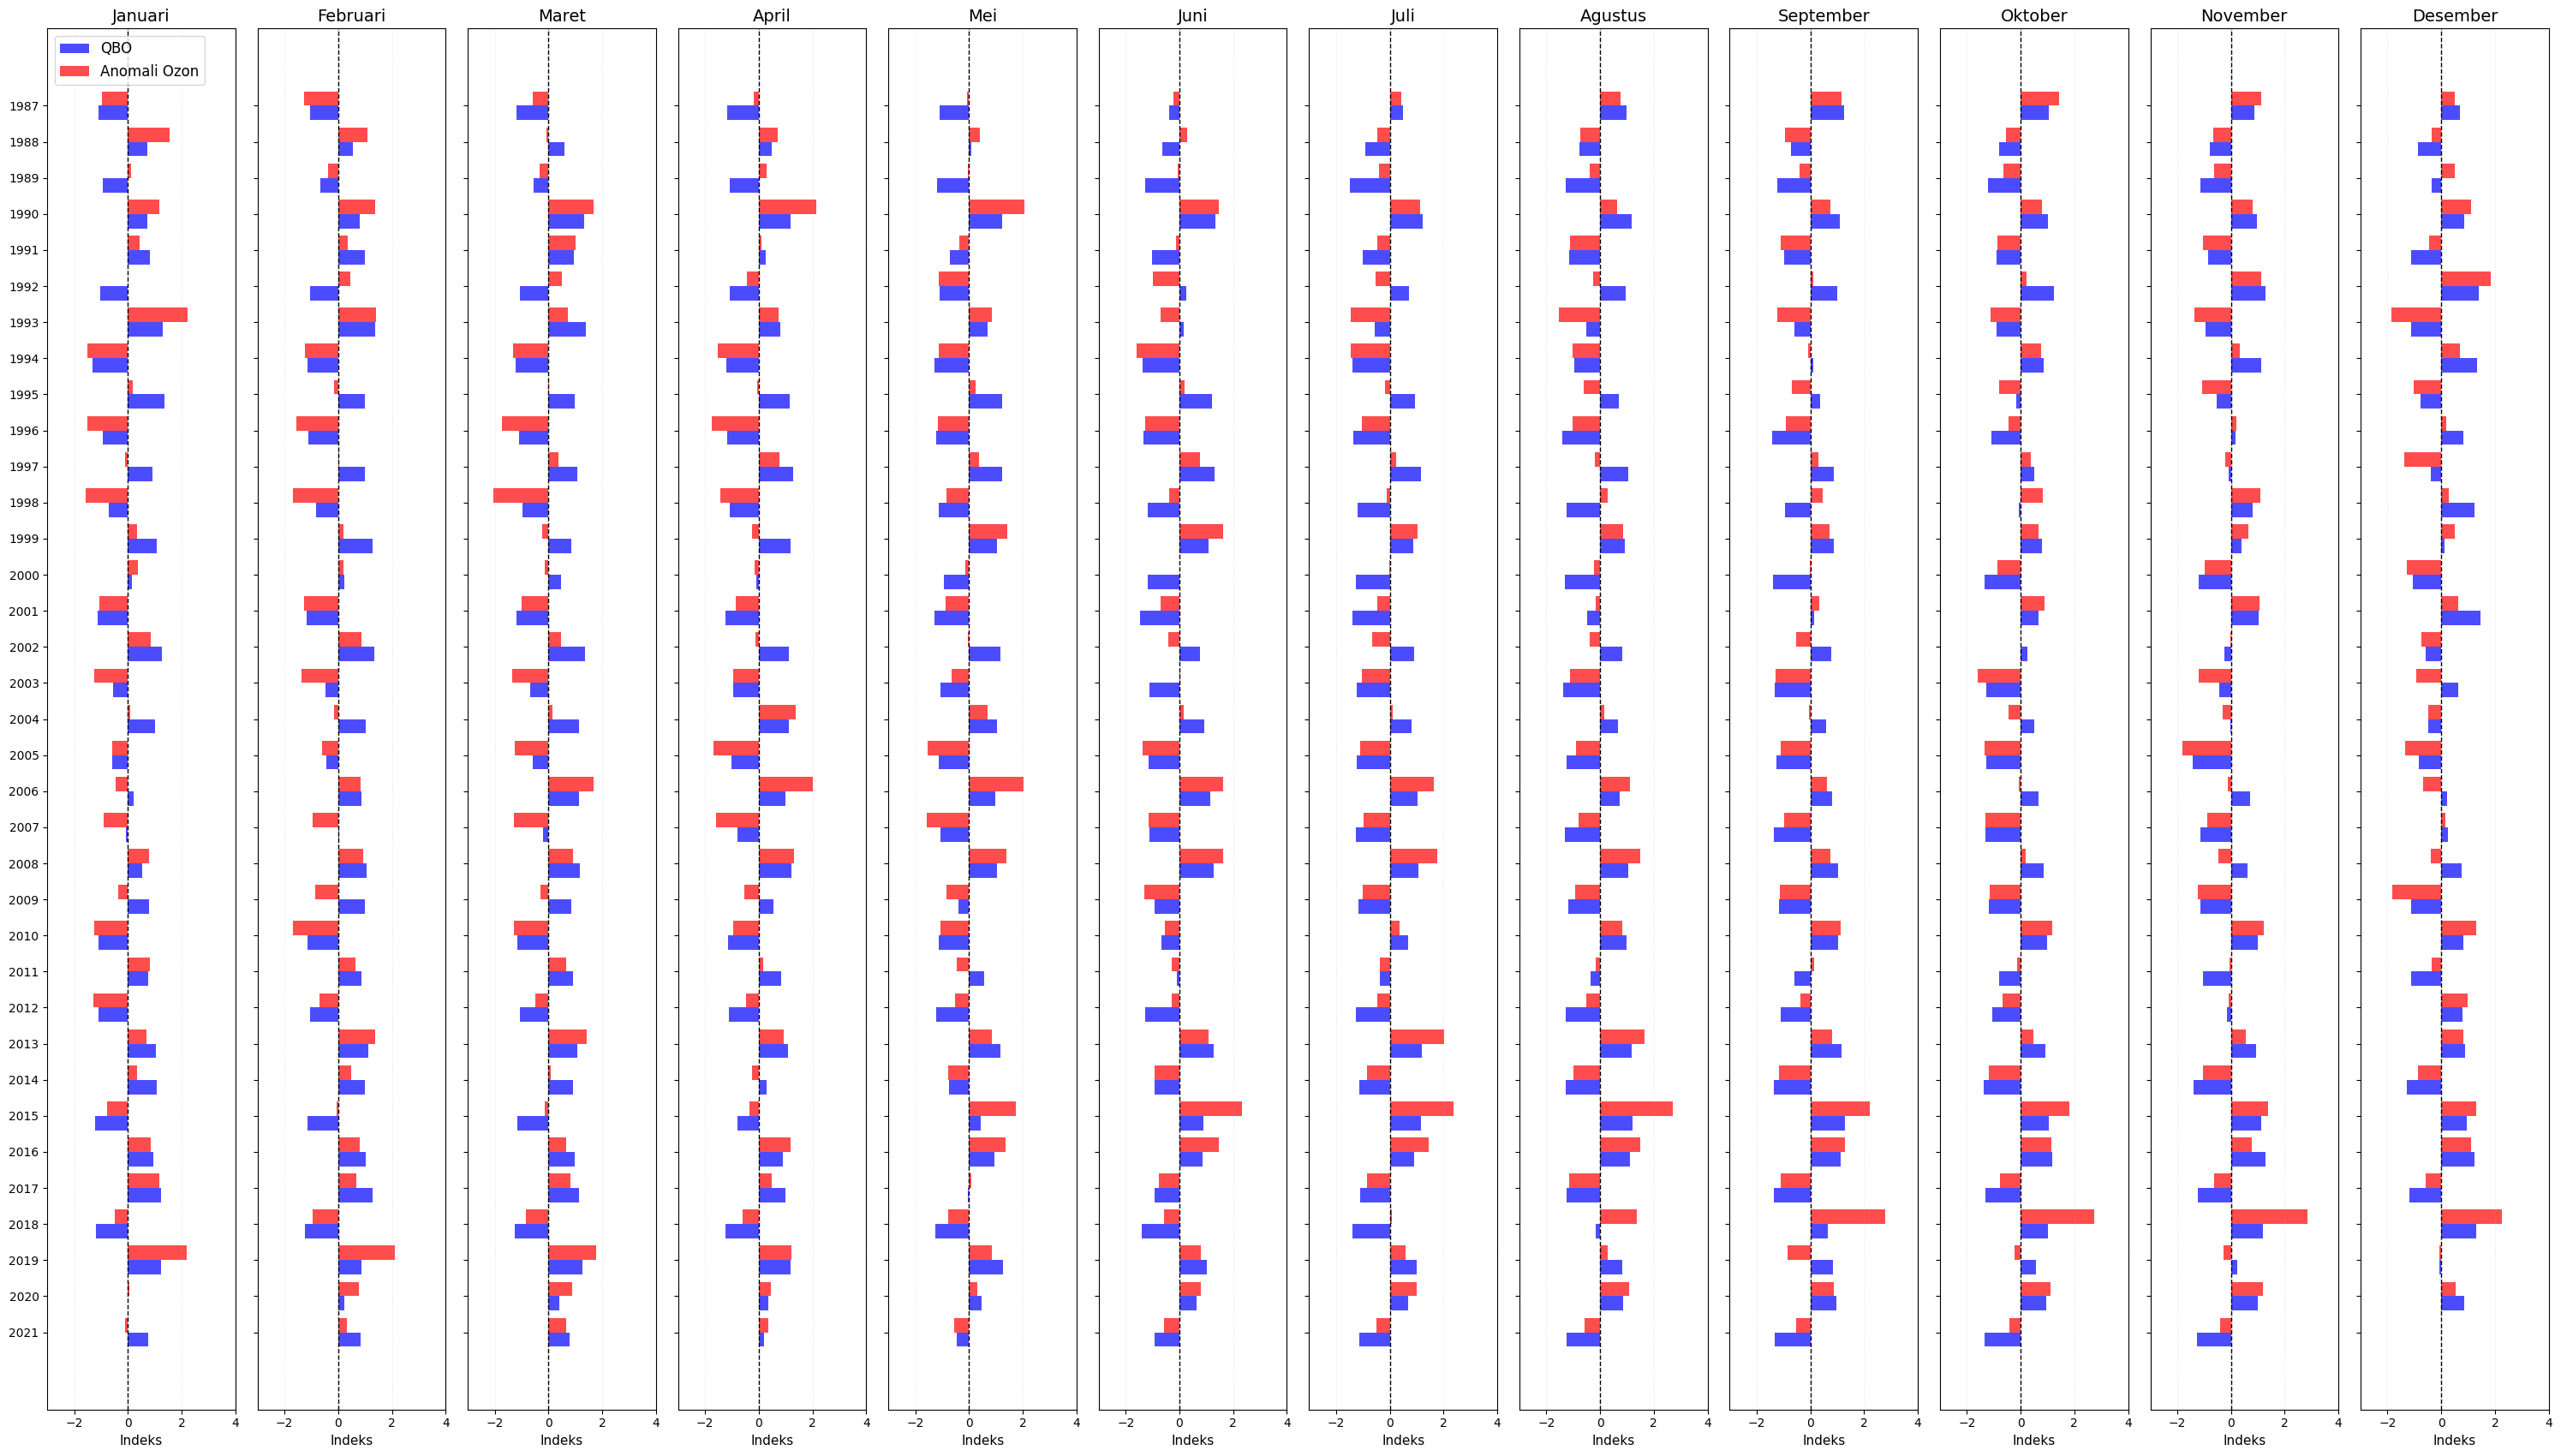

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
ausmi = pd.read_excel('QBO Data.xlsx')
ch_anom = pd.read_excel('Ozone_Anomaly.xlsx')

# Parsing tanggal & ekstraksi komponen
for df in [ausmi, ch_anom]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

# Gabungkan data
merged = pd.merge(ch_anom, ausmi, on=['Date', 'Year', 'Month'], suffixes=('_CH', '_AUSMI'))

# Hitung batas X otomatis dari keseluruhan data
x_min = min(merged['QBO'].min(), merged['TCO'].min())
x_max = max(merged['QBO'].max(), merged['TCO'].max())

# Tambahkan margin dan bulatkan agar rapi
x_margin = 0.5
x_lim = (np.floor(x_min - x_margin), np.ceil(x_max + x_margin))

# Setup plot
fig, axes = plt.subplots(nrows=1, ncols=12, figsize=(30, 18), sharey=True)
fig.subplots_adjust(wspace=0.1)

# Nama bulan
month_names = ['Januari', 'Februari', 'Maret', 'April', 'Mei', 'Juni',
               'Juli', 'Agustus', 'September', 'Oktober', 'November', 'Desember']

# Daftar tahun unik (dari terbaru ke terlama)
years = sorted(merged['Year'].unique(), reverse=True)
y_pos = np.arange(len(years))

# Loop untuk setiap bulan
for i, ax in enumerate(axes):
    month = i + 1
    data = merged[merged['Month'] == month]

    # Pastikan urutan tahun konsisten
    data = data.set_index('Year').reindex(years).reset_index()

    # Plot batang horizontal
    ax.barh(y_pos - 0.2, data['QBO'], height=0.4, color='blue', alpha=0.7, label='QBO' if i == 0 else "")
    ax.barh(y_pos + 0.2, data['TCO'], height=0.4, color='red', alpha=0.7, label='Anomali Ozon' if i == 0 else "")

    ax.set_title(month_names[i], fontsize=14)

    # Gunakan batas x otomatis
    ax.set_xlim(x_lim)

    # Buat grid dan garis nol
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.grid(True, axis='x', linestyle=':', alpha=0.3)

    # Tambahkan label tahun
    ax.set_yticks(y_pos)
    ax.set_yticklabels(years, fontsize=10)
    ax.set_xlabel('Indeks', fontsize=11)

# Tambahkan legenda sekali
axes[0].legend(loc='upper left', fontsize=12)

# Tata letak & tampilkan
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
